<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Web APIs & NLP

## Problem Statement

We are a group of home improvement consultants that provide suggestions on how to refurbish the houses in selected neighborhoods in Ames, Iowa, including selecting the best features for homeowners to renovate, in order to improve the value of their homes in a cost-effective way.

Based on the provided data, we will:
- build several multiple linear regression models and select one best-performing model as our production model
- based on our production model, explore and  recommend important features for home improvment
- build models for selected neighorboods, explore and  recommend important features for home improvment

## Background

House value are influented by the following factors:([*source*](https://www.opendoor.com/w/blog/factors-that-influence-home-value))
- Neighborhood comps
- Location
- Home size and usable space
- Age and condition
- Upgrades and updates
- The local market
- Economic indicators
- Interest rates

As home improvement consultants, we are more interested at the factors or features which can be improved on the exsiting houses. 


## Dataset and Data Directory
- The dataset  ([*source*](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data)) contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.
- The Dataset has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). ([*source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))
- Some important features are listed as below 


|Feature|Type|Description|
|---|---|---|
|**SalePrice**|*Continuous*|sale price, we will treat it as house value| 
|**Neighborhood**|*nominal*|Physical locations within Ames city limits|
|**Overall Qual**|*ordinal*|Rates the overall material and finish of the house|
|**Year Built**|*Discrete*|Original construction date|
|**Mas Vnr Type**|*nominal*|Masonry veneer type|
|**Mas Vnr Area**|*Continuous*|PMasonry veneer area in square feet|
|**Foundation**|*Nominal*| Type of foundation|
|**BsmtFin Type 1**|*Ordinal*| Rating of basement finished area| 
|**BsmtFin SF 1**|*Continuous*|Type 1 finished square feet|
|**Total Bsmt SF**|*Continuous*|Total square feet of basement area|
|**Gr Liv Area**|*Continuous*|Above grade (ground) living area square feet|
|**Fireplaces**|*Discrete*|Number of fireplaces|
|**Garage Area**|*Continuous*|Size of garage in square feet|
|**Open Porch SF**|*Continuous*| Open porch area in square feet|
|**HeatingQC**|*Ordinal*|Heating quality and condition|
|**Bedroom**|*Discrete*|Bedrooms above grade (does NOT include basement bedrooms)|
|**Kitchen**|*Discrete*|Kitchens above grade|
|**KitchenQual**|*Ordinal*|Kitchen quality|
|**TotRmsAbvGrd**|*Discrete*|Total rooms above grade (does not include bathrooms)|


In [70]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [154]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay, roc_auc_score
from sklearn.naive_bayes import MultinomialNB,ComplementNB,GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay




import pickle
import requests
import time

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV




# define some functions

In [72]:
def get_top_ngram(corpus,  n_gram=1, top_n=10):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    x,y=map(list,zip(*(words_freq[:top_n])))
    sns.barplot(x=y,y=x)
    return words_freq[:top_n]

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            #words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(15, 8))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

In [73]:
from wordcloud import WordCloud, STOPWORDS


def plot_wordcloud(corpus):
    
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq_dict = dict(sorted(words_freq, key = lambda x: x[1], reverse=True))
    #x,y=map(list,zip(*(words_freq)))
    
    
    wordcloud = WordCloud( background_color='white',
                           stopwords=set(STOPWORDS),
                           min_word_length =3,
                           max_words=200,
                           max_font_size=30, 
                           scale=4,
                           random_state=1
                         )

    wordcloud=wordcloud.generate_from_frequencies(words_freq_dict)

    fig = plt.figure(1, figsize=(15, 8))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

In [74]:
def run_model(gs, X_train, y_train, X_test, y_test ):
    gs.fit(X_train, y_train)
    
    print("best_params: ")
    print(gs.best_params_)
    
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    perc_diff = np.abs(test_score/train_score*100-100)
    
    print(f'\nroc_auc_score on training set: {train_score:.3f}')
    print(f'roc_auc_score on testing set: {test_score:.3f}')
    print(f'perc_diff: {perc_diff:.1f} %\n')
    
    # Get predictions
    preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    accur_score = accuracy_score(y_test, preds)
    print(f'accuracy_score on testing set: {accur_score:.3f}\n')
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, preds)
    cm_df = pd.DataFrame(cm, columns=['pred AskWomen', 'pred AskMen'], 
                         index=['actual AskWomen', 'actual AskMen'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    #plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    plt.show()


#the function will:
#1. get the coefficients from a GridSearchCV
#2. create a dateframe with those coefficients and their feature
#3. run t-test on predictors and calculate the p-value
#4. calculate the VIF
#5. merge all into one dataFrame and return the datframe
def get_coefs(gs, X, y):
    # get the coefficients
    coefs = gs.best_estimator_.named_steps["classifier"].coef_
    
    #create dataframe
    df_coefs =  pd.DataFrame(list(zip(,coefs)))
    df_coefs.columns = ['feature', 'coef']
    df_coefs['abs_coef']=np.abs(df_coefs['coef'])

    #sort the dataframe by the descending order of 'abs_coef'
    df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
    df_coefs.reset_index(drop=True,inplace=True)
    #df_coefs.head(150)  
    
    #run t-test on predictors and calculate the p-value
    X_add = add_constant(X)
    model_ols = sm.OLS(y, X).fit()
    d = {}
    for i in X.columns.tolist():
        d[f'{i}'] = model_ols.pvalues[i]
    df_pvalue= pd.DataFrame(d.items(), columns=['feature', 'p-value'])
    
    #calculate the VIF
    df_vif = pd.DataFrame([variance_inflation_factor(X_add.values, i) 
               for i in range(X_add.shape[1])], 
              index=X_add.columns)
    df_vif.reset_index(drop=False,inplace=True) 
    df_vif.columns=['feature', 'vif']
    #df_vif.head(100)
    
    df_coefs = pd.merge(df_coefs, df_vif,on='feature' )
    df_coefs = pd.merge(df_coefs, df_pvalue,on='feature' )
     
    
    return df_coefs

# pickle

In [75]:
pick_dict = pickle.load(open('../datasets/data.pkl', 'rb'))

In [76]:
df_askwomen = pick_dict['df_askwomen']
print(df_askwomen.shape)
df_askwomen.head()

(1999, 70)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_template_id,author_flair_text_color,author_flair_background_color,banned_by,author_cakeday,post_hint,preview,call_to_action,category
0,[],False,naughtygeekyredditor,None,[],None,text,t2_6ch7kb03,False,False,False,[],False,False,1658491375,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58vxv,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,True,all_ads,/r/AskWomen/comments/w58vxv/how_often_do_you_m...,False,6,automod_filtered,1658491386,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822025,public,top,nsfw,How often do you masturbate?,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,promo_adult_nsfw,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491121,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58shp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58shp/how_would_you_hear...,False,6,moderator,1658491132,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822016,public,top,self,How would you hear “No one could ever be as at...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491016,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58rbp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58rbp/no_one_could_ever_...,False,6,moderator,1658491027,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822012,public,top,self,“No one could ever be as attracted to you as I...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,tsbxred,female,[],♀,text,t2_om297,False,False,False,[],False,False,1658490938,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58qi4,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58qi4/what_is_your_exper...,False,6,automod_filtered,1658490949,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822007,public,top,self,What is your experience of staying with a miso...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,8106c61a-c8aa-11e1-a771-12313b0ce1e2,dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Spiritual-Ad8437,None,[],None,text,t2_7xt6wpkw,False,False,False,[],False,False,1658490589,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58mnf,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58mnf/why_is_it_more_soc...,False,6,automod_filtered,1658490600,1,[removed],True,False,False,AskWomen,t5_2rxrw,3821993,public,top,self,Why is it more socially acceptable when a woma...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df_askmen = pick_dict['df_askmen']
print(df_askmen.shape)
df_askmen.head()

(2000, 67)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_background_color,author_flair_template_id,author_flair_text_color,banned_by,post_hint,preview,author_cakeday
0,[],False,capuccinohedgie,None,[],None,text,t2_8q465stc,False,False,False,[],False,False,1658491492,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58xe...,{},w58xer,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58xer/is_wearing_a_wig_a_t...,False,6,moderator,1658491502,1,[removed],True,False,False,AskMen,t5_2s30g,4000940,public,self,Is wearing a wig a turn off,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58xe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,wondroussarah,None,[],None,text,t2_976wlsse,False,False,False,[],False,False,1658491238,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58u6...,{},w58u6v,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58u6v/do_men_come_up_to_mo...,False,6,moderator,1658491249,1,[removed],True,False,False,AskMen,t5_2s30g,4000934,public,self,Do men come up to MOST women to ask for relati...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58u6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Commercial_Fuel_3519,None,[],None,text,t2_3l9elkem,False,False,False,[],False,False,1658490909,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58q6...,{},w58q67,False,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58q67/you_have_a_16_year_o...,False,6,NaN,1658490920,1,,True,False,False,AskMen,t5_2s30g,4000920,public,self,You have a 16 year old daughter who generally ...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58q6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,ZoneWestern464,None,[],None,text,t2_eu514prg,False,False,False,[],False,False,1658490844,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pg...,{},w58pg8,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58pg8/mods_are_vir/,False,6,moderator,1658490855,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,mods are vir....,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pg...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Recent-Manager-9875,None,[],None,text,t2_pemzjrr2,False,False,False,[],False,False,1658490840,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pe...,{},w58peh,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58peh/do_you_have_a_specif...,False,6,moderator,1658490850,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,Do you have a specific hair routine and what k...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df_askwomen = df_askwomen.loc[:,['subreddit','author', 'title','selftext']]

In [79]:
df_askmen = df_askmen.loc[:,['subreddit', 'author', 'title','selftext']]

## Data cleaning and EDA : df_askwomen

### handle null values

In [80]:
df_askwomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1999 non-null   object
 1   author     1999 non-null   object
 2   title      1999 non-null   object
 3   selftext   1992 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [81]:
(df_askwomen.isnull().sum()/len(df_askwomen)*100).sort_values(ascending=False)

selftext    0.35
subreddit   0.00
author      0.00
title       0.00
dtype: float64

In [82]:
df_askwomen['selftext']=df_askwomen['selftext'].fillna('')

In [83]:
(df_askwomen.isnull().sum()/len(df_askwomen)*100).sort_values(ascending=False)

subreddit   0.00
author      0.00
title       0.00
selftext    0.00
dtype: float64

In [84]:
df_askwomen['selftext']=df_askwomen['selftext'].astype("str")

## EDA: 'title'

Text(0, 0.5, 'count')

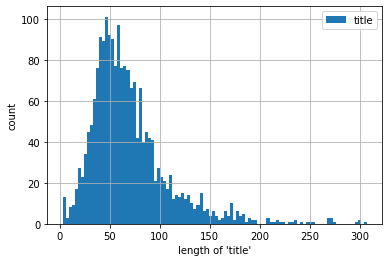

In [85]:
ax = df_askwomen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")

In [86]:
#df_askwomen.sort_values(by='title', ascending=True, inplace=True)
df_askwomen[df_askwomen['title'].str.len()<15]

,subreddit,author,title,selftext
9,AskWomen,Zostrianos_696,Why victims?,[removed]
72,AskWomen,ygphohunnid,Who can help??,[removed]
74,AskWomen,SmellResponsible2816,what is this,[removed]
117,AskWomen,charismaticlass,what do i do?,[removed]
209,AskWomen,MJB4890,Which one,[removed]
252,AskWomen,No-Toe-1966,why?,[removed]
253,AskWomen,No-Toe-1966,why,[removed]
263,AskWomen,No_Principle_8660,tell me why,[removed]
384,AskWomen,mommypiage,who's next?,[removed]
407,AskWomen,tomybestself,What is a man?,[removed]


In [87]:
df_askwomen.shape

(1999, 4)

In [88]:
#delete records with len('title') < 15
#df_askwomen = df_askwomen[df_askwomen['title'].str.len()>15]
df_askwomen.shape

(1999, 4)

#### EDA : 'selftext'


Text(0, 0.5, 'count')

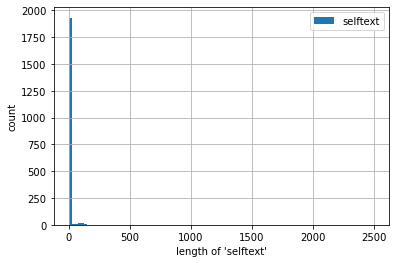

In [89]:
ax = df_askwomen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")

In [90]:
df_askwomen[df_askwomen['selftext'].str.len()<15]

,subreddit,author,title,selftext
0,AskWomen,naughtygeekyredditor,How often do you masturbate?,[removed]
1,AskWomen,kia-audi-spider-legs,How would you hear “No one could ever be as at...,[removed]
2,AskWomen,kia-audi-spider-legs,“No one could ever be as attracted to you as I...,[removed]
3,AskWomen,tsbxred,What is your experience of staying with a miso...,[removed]
4,AskWomen,Spiritual-Ad8437,Why is it more socially acceptable when a woma...,[removed]
...,...,...,...,...
1994,AskWomen,UltimateSeductive,What is the worst response I could get to the ...,[removed]
1995,AskWomen,Certain_Dark6013,Why do so many women have no problem with adul...,[removed]
1996,AskWomen,Loki_8456,How do you feel meeting people online vs in pe...,[removed]
1997,AskWomen,LordoftheRingbeef,45(M) how do i tell my wife 44(F) that she isn...,[removed]


In [91]:
df_askwomen['selftext'].replace('[removed]','', inplace=True, regex=True)


In [92]:
df_askwomen[df_askwomen['selftext'].str.contains('[removed]')].count()

subreddit    0
author       0
title        0
selftext     0
dtype: int64

### create new column 'title + selftext'

In [93]:
df_askwomen['title + selftext'] = df_askwomen['title'] + df_askwomen['selftext']
df_askwomen.head()

,subreddit,author,title,selftext,title + selftext
0,AskWomen,naughtygeekyredditor,How often do you masturbate?,[],How often do you masturbate?[]
1,AskWomen,kia-audi-spider-legs,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,AskWomen,kia-audi-spider-legs,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,AskWomen,tsbxred,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,AskWomen,Spiritual-Ad8437,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...


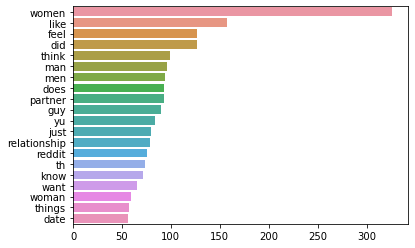

In [94]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=1, top_n=20)


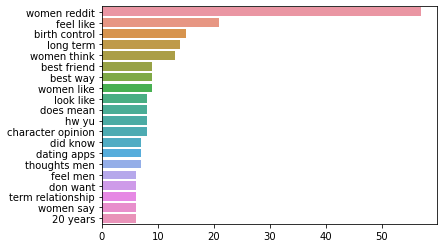

In [95]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=2, top_n=20)

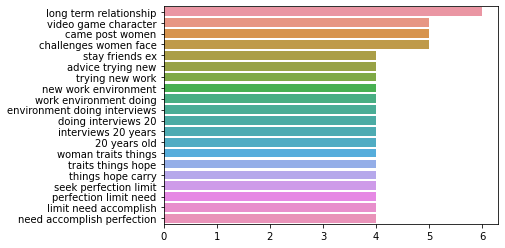

In [96]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=3, top_n=20)

vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
words_freq_dict = dict(sorted(words_freq, key = lambda x: x[1], reverse=True))
    

words_freq_dict

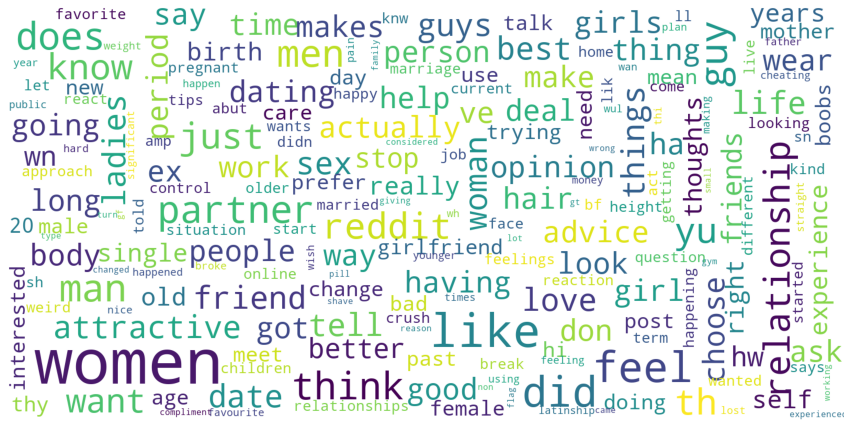

In [97]:
plot_wordcloud(df_askwomen['title + selftext'])

## Data cleaning and EDA : df_askmen

### handle null values

In [98]:
df_askmen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2000 non-null   object
 1   author     2000 non-null   object
 2   title      2000 non-null   object
 3   selftext   1979 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [99]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

selftext    1.05
subreddit   0.00
author      0.00
title       0.00
dtype: float64

In [100]:
df_askmen['selftext']=df_askmen['selftext'].fillna('')

In [101]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

subreddit   0.00
author      0.00
title       0.00
selftext    0.00
dtype: float64

In [102]:
df_askmen['selftext']=df_askmen['selftext'].astype("str")

## EDA: 'title'

Text(0, 0.5, 'count')

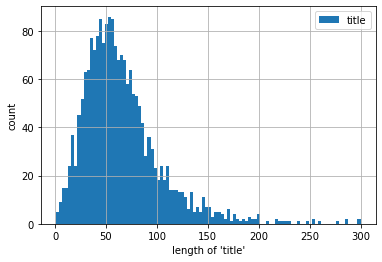

In [103]:
ax = df_askmen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")

In [104]:
#df_askwomen.sort_values(by='title', ascending=True, inplace=True)
df_askmen[df_askmen['title'].str.len()<10]

,subreddit,author,title,selftext
101,AskMen,Patient_Ad_7265,Help,[removed]
113,AskMen,PsychologicalBee2031,Help me.,[removed]
137,AskMen,No_Victory_1513,Cooking,[removed]
186,AskMen,lykme2,Why???,[removed]
241,AskMen,shego3,Venting,[removed]
468,AskMen,111riot,wha,[removed]
473,AskMen,Practical_Pension421,DM,[removed]
474,AskMen,Practical_Pension421,s,[removed]
515,AskMen,Febastroph,Nsfw,[removed]
540,AskMen,ocdinmymind,help pls,[removed]


In [105]:
df_askmen.shape

(2000, 4)

In [106]:
#delete records with len('title') < 15
#df_askmen = df_askmen[df_askmen['title'].str.len()>10]
df_askmen.shape

(2000, 4)

#### EDA : 'selftext'


Text(0, 0.5, 'count')

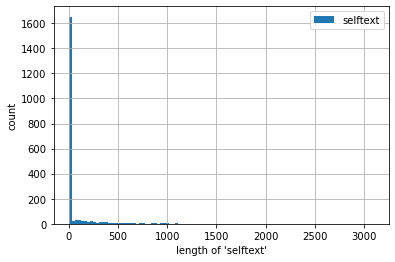

In [107]:
ax = df_askmen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")

In [108]:
df_askmen[df_askmen['selftext'].str.len()<15]

,subreddit,author,title,selftext
0,AskMen,capuccinohedgie,Is wearing a wig a turn off,[removed]
1,AskMen,wondroussarah,Do men come up to MOST women to ask for relati...,[removed]
2,AskMen,Commercial_Fuel_3519,You have a 16 year old daughter who generally ...,
3,AskMen,ZoneWestern464,mods are vir....,[removed]
4,AskMen,Recent-Manager-9875,Do you have a specific hair routine and what k...,[removed]
...,...,...,...,...
1995,AskMen,skinticket02,Men ( both gay and straight) are a lot more sh...,
1996,AskMen,Sofia_Andre_OF,What sexual desires/preferences are you afraid...,[removed]
1997,AskMen,manhadz,When has waiting for the “girl of your dreams”...,
1998,AskMen,Any-Discussion-5934,Why do some men keep calling themselves STRAIG...,[removed]


In [109]:
df_askmen['selftext'].replace('[removed]','', inplace=True, regex=True)


In [110]:
df_askmen[df_askmen['selftext'].str.contains('[removed]')].count()

subreddit    0
author       0
title        0
selftext     0
dtype: int64

In [111]:
df_askmen[df_askmen['selftext'].str.contains('selftext')].count()

subreddit    0
author       0
title        0
selftext     0
dtype: int64

### create new column 'title + selftext'

In [112]:
df_askmen['title + selftext'] = df_askmen['title'] + df_askmen['selftext']
df_askmen.head()

,subreddit,author,title,selftext,title + selftext
0,AskMen,capuccinohedgie,Is wearing a wig a turn off,[],Is wearing a wig a turn off[]
1,AskMen,wondroussarah,Do men come up to MOST women to ask for relati...,[],Do men come up to MOST women to ask for relati...
2,AskMen,Commercial_Fuel_3519,You have a 16 year old daughter who generally ...,,You have a 16 year old daughter who generally ...
3,AskMen,ZoneWestern464,mods are vir....,[],mods are vir....[]
4,AskMen,Recent-Manager-9875,Do you have a specific hair routine and what k...,[],Do you have a specific hair routine and what k...


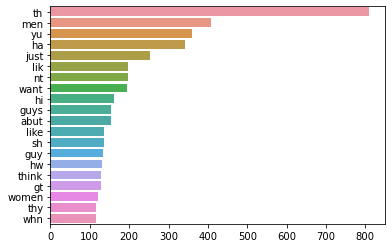

In [113]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=1, top_n=20)


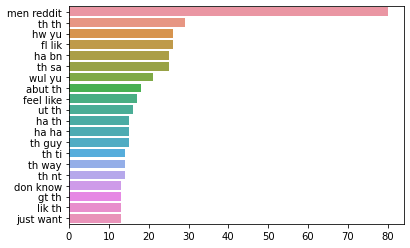

In [114]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=2, top_n=20)

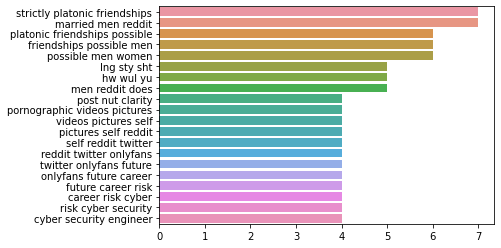

In [115]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=3, top_n=20)

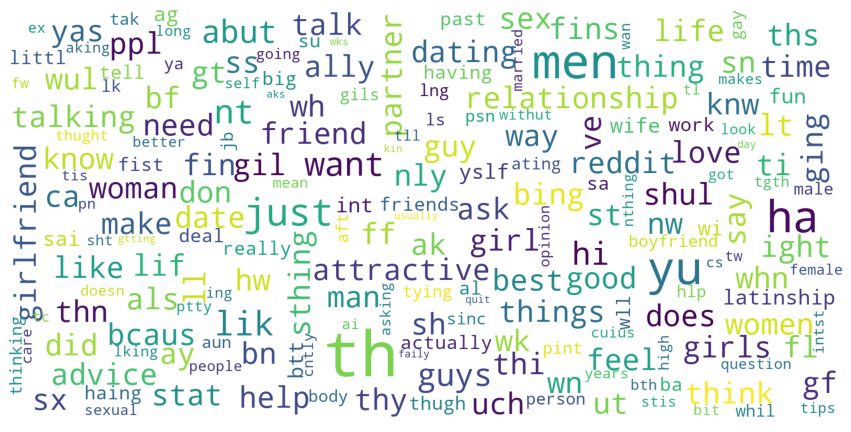

In [116]:
plot_wordcloud(df_askmen['title + selftext'])

### Convert subreddit into binary labels:

In [117]:
df = pd.concat(objs=[df_askwomen,df_askmen], axis=0) 
df = df.reset_index(drop=True)

In [118]:

df['subreddit'] = df['subreddit'].map({'AskWomen' : 0, 'AskMen' : 1})
df.head()

,subreddit,author,title,selftext,title + selftext
0,0,naughtygeekyredditor,How often do you masturbate?,[],How often do you masturbate?[]
1,0,kia-audi-spider-legs,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,0,kia-audi-spider-legs,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,0,tsbxred,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,0,Spiritual-Ad8437,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...


In [119]:
X = df['title + selftext']
y = df['subreddit']

In [120]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

1   0.50
0   0.50
Name: subreddit, dtype: float64

## Pre-Processing

In [121]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=2333)

# Matrics
- to use ROC AUC to compare models
- our data is balanced
- Both positive and negative are the same important to us

## Modeling Using the CountVectorizer + Multinomial Naive Bayes

best_params: 
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

roc_auc_score on training set: 0.903
roc_auc_score on testing set: 0.785
perc_diff: 13.0 %

accuracy_score on testing set: 0.672

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            632           28
actual AskMen              405          255

plot confusion matrix and ROC curve


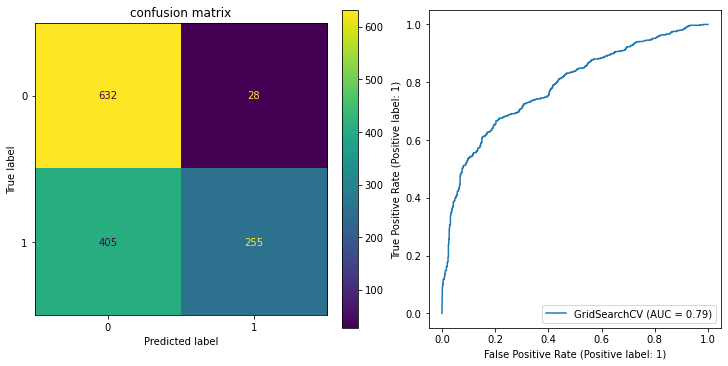

In [122]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_cvec_mnb = Pipeline([
                ('cvec', CountVectorizer()),
                ('mnb', MultinomialNB())
                ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_cvec_mnb_params = {
                'cvec__max_features': [500, 1_000, 2_000, 3_000, 4_000, 5_000],
                'cvec__min_df': [2, 3],
                'cvec__max_df': [.9, .95],
                'cvec__ngram_range': [(1,1), (1,2)]
                }

# Instantiate GridSearchCV.
gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb, # what object are we optimizing?
                  param_grid=pipe_cvec_mnb_params, # what parameters values are we searching?
                  n_jobs = -1,
                  scoring='roc_auc',
                  cv=3) # 5-fold cross-validation

run_model(gs_cvec_mnb, X_train, y_train, X_test, y_test )

In [123]:
#df_coefs = get_coefs(gs_cvec_mnb, X, y)

## Modeling Using the TfidfVectorizer + RandomForest

best_params: 
{'classifier__class_weight': None, 'classifier__max_depth': 6, 'classifier__n_estimators': 1000, 'tvec__max_features': 350, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

roc_auc_score on training set: 0.871
roc_auc_score on testing set: 0.801
perc_diff: 8.1 %

accuracy_score on testing set: 0.750

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            573           87
actual AskMen              243          417

plot confusion matrix and ROC curve


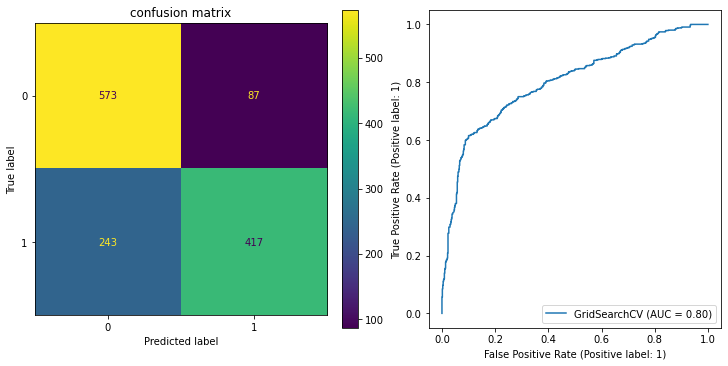

Wall time: 2min 9s


In [124]:
%%time
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_rf = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier',RandomForestClassifier(random_state=42))
                    ])


# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_rf_params = {
                    #params of TfidfVectorizer
                    'tvec__max_features': [350,400,500],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    #params of random forest
                    'classifier__n_estimators' : [500, 1000],
                    'classifier__max_depth' : [4,5,6],
                    'classifier__class_weight' : [None, {0:1,1:5}]
                    }


# Instantiate GridSearchCV.
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, # what object are we optimizing?
                        param_grid = pipe_tvec_rf_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

run_model(gs_tvec_rf, X_train, y_train, X_test, y_test )

best_params: 
{'classifier__class_weight': None, 'classifier__max_depth': 6, 'classifier__n_estimators': 1000, 'tvec__max_features': 350, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

roc_auc_score on training set: 0.801
roc_auc_score on testing set: 0.741
perc_diff: 7.5 %

accuracy_score on testing set: 0.657

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            609           51
actual AskMen              402          258

plot confusion matrix and ROC curve


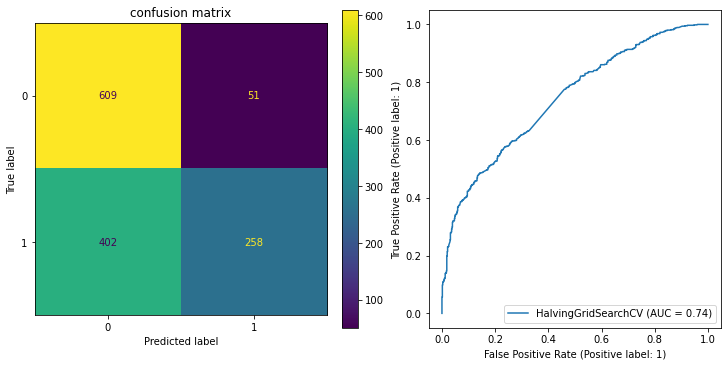

Wall time: 2min 27s


In [125]:
%%time
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_rf = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier',RandomForestClassifier(random_state=42))
                    ])


# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_rf_params = {
                    #params of TfidfVectorizer
                    'tvec__max_features': [350,400,500],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    #params of random forest
                    'classifier__n_estimators' : [500, 1000],
                    'classifier__max_depth' : [4,5,6],
                    'classifier__class_weight' : [None, {0:1,1:5}]
                    }


# Instantiate GridSearchCV.
hgs_tvec_rf = HalvingGridSearchCV(pipe_tvec_rf, # what object are we optimizing?
                        param_grid = pipe_tvec_rf_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

run_model(hgs_tvec_rf, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + LogisticRegression

best_params: 
{'classifier__C': 1, 'classifier__penalty': 'l1', 'tvec__max_features': 950, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.867
roc_auc_score on testing set: 0.834
perc_diff: 3.9 %

accuracy_score on testing set: 0.777

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            542          118
actual AskMen              176          484

plot confusion matrix and ROC curve


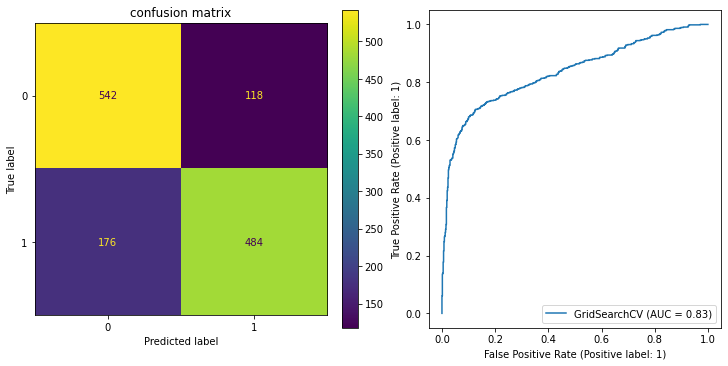

Wall time: 7.15 s


In [127]:
%%time
#good random key:2333, 888, 1444,2222
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=2333)

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_lr = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', LogisticRegression(solver='liblinear'))
                    ])


# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_lr_params = {
                    'tvec__max_features': [ 900,950,1_000, 1_100],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__C' :  [10**-1, 10**0, 10**1],
                    'classifier__penalty'  : ['l1','l2'],
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }


# Instantiate GridSearchCV.
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # what object are we optimizing?
                        param_grid = pipe_tvec_lr_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


run_model(gs_tvec_lr, X_train, y_train, X_test, y_test )

In [132]:
X.vocabulary =gs_tvec_lr.best_estimator_.named_steps['tvec'].vocabulary_

In [133]:
X.vocabulary

{'what': 792,
 'is': 359,
 'the': 678,
 'reason': 576,
 'what is': 801,
 'is the': 365,
 'how': 313,
 'do': 172,
 'stop': 641,
 'with': 845,
 'thighs': 689,
 'and': 47,
 'need': 477,
 'help': 303,
 'how do': 317,
 'ladies': 398,
 'something': 630,
 'that': 672,
 'makes': 438,
 'you': 891,
 'lose': 427,
 'to': 718,
 'man': 442,
 'ladies what': 399,
 'is something': 362,
 'makes you': 439,
 'should': 608,
 'what should': 804,
 'should do': 610,
 'where': 819,
 'have': 295,
 'had': 283,
 'most': 463,
 'women': 866,
 'have you': 299,
 'you had': 909,
 'the most': 682,
 'your': 930,
 'ideal': 332,
 'is your': 368,
 'your ideal': 936,
 'does': 183,
 'an': 39,
 'ex': 201,
 'look': 424,
 'like': 413,
 'what does': 799,
 'with an': 846,
 'can': 130,
 'my': 468,
 'current': 159,
 'partner': 533,
 'they': 687,
 're': 572,
 'not': 487,
 'good': 268,
 'without': 857,
 'their': 684,
 'feelings': 214,
 'it': 371,
 'th': 663,
 'wi': 839,
 'pn': 556,
 'his': 309,
 'int': 354,
 'just': 384,
 'ging': 257

In [130]:
X_train

697                                 What is the reason?[]
1442    How do u stop chub rub / chafing with thick th...
1710    Ladies, What is something that makes you lose ...
1546                                  what should I do?[]
2171    Where have you had the most success meeting wo...
                              ...                        
1684    What do you think is the reason behind that on...
522                                Feather or rock? Why[]
1519    Girls, I'm just curious to know what turns you...
3577              What Would You Do if in My Situation?[]
3015                                 What do you think?[]
Name: title + selftext, Length: 2679, dtype: object

In [140]:
best_tvec = gs_tvec_lr.best_estimator_.named_steps['tvec']
best_lr = gs_tvec_lr.best_estimator_.named_steps['classifier']

In [148]:
features_list=best_tvec.get_feature_names_out()
print(features_list)

['10' '20' '20s' '24' '30' '30s' 'aag' 'about' 'about your' 'abut'
 'abut it' 'ach' 'across' 'act' 'actually' 'advice' 'advice on'
 'advice would' 'aft' 'after' 'ag' 'again' 'against' 'age' 'ai' 'aic' 'ak'
 'aking' 'aks' 'al' 'al with' 'all' 'ally' 'aln' 'als' 'also' 'always'
 'am' 'amp' 'an' 'an ha' 'an it' 'an sh' 'an th' 'an that' 'an what'
 'anal' 'and' 'and how' 'and what' 'and why' 'another' 'anth' 'any' 'anyn'
 'anyone' 'anyone else' 'anything' 'approach' 'are' 'are some' 'are the'
 'are you' 'are your' 'around' 'as' 'as woman' 'ask' 'asked' 'asking'
 'ass' 'at' 'at all' 'at home' 'at th' 'at the' 'at what' 'ath' 'ating'
 'attntin' 'attracted' 'attracted to' 'attractive' 'aun' 'average' 'ay'
 'ayb' 'ba' 'back' 'bad' 'bc' 'bcaus' 'be' 'be more' 'because' 'become'
 'bed' 'been' 'before' 'being' 'best' 'best friend' 'better' 'between'
 'bf' 'big' 'biggest' 'bing' 'birth' 'birth control' 'bit' 'bli' 'bn'
 'body' 'boobs' 'boyfriend' 'break' 'bst' 'bth' 'btt' 'but' 'but it'
 'but nt' 

In [195]:
# get the coefficients
coefs = best_lr.coef_[0]

df_coefs =  pd.DataFrame(list(zip(features_list,coefs)))  

df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

#sort the dataframe by the descending order of 'abs_coef'
df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.set_index('feature',inplace=True)
df_coefs.head(15)

,coef,abs_coef
feature,,
how,-8.10,8.10
women of,-7.65,7.65
ladies,-7.27,7.27
what,-7.24,7.24
men of,7.15,7.15
who,-6.44,6.44
why,-5.55,5.55
men,5.07,5.07
which,-4.81,4.81


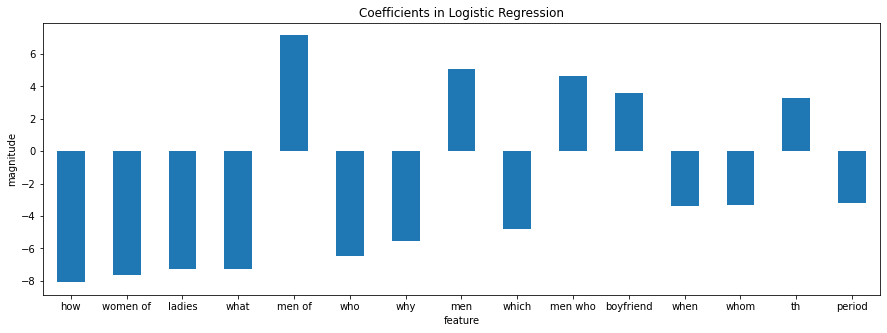

In [192]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
df_coefs['coef'].head(15).plot(kind = 'bar',ylabel="magnitude")
plt.title('Coefficients in Logistic Regression')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

best_params: 
{'classifier__C': 1, 'classifier__penalty': 'l2', 'tvec__max_features': 925, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.898
roc_auc_score on testing set: 0.821
perc_diff: 8.5 %

accuracy_score on testing set: 0.752

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            518          142
actual AskMen              185          475

plot confusion matrix and ROC curve


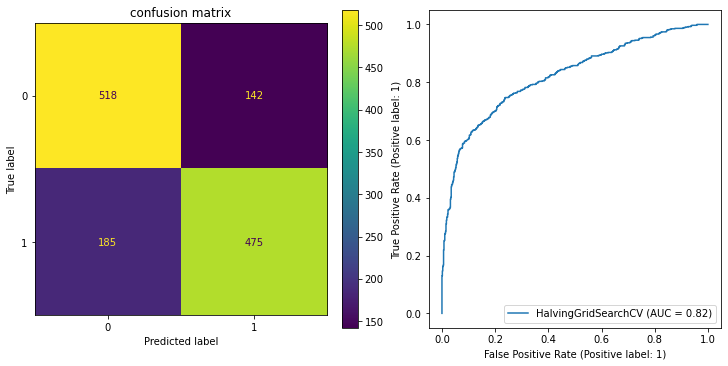

Wall time: 3.68 s


In [66]:
%%time
#good random key:2333, 888, 1444,2222
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=2333)

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_lr = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', LogisticRegression(solver='liblinear'))
                    ])


# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_lr_params = {
                    'tvec__max_features': [ 850,875, 900, 925, 950,975],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__C' :  [10**-1, 10**0, 10**1],
                    'classifier__penalty'  : ['l1','l2'],
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }


# Instantiate GridSearchCV.
hgs_tvec_lr = HalvingGridSearchCV(pipe_tvec_lr, # what object are we optimizing?
                        param_grid = pipe_tvec_lr_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc',
                        random_state = 111
                         )


run_model(hgs_tvec_lr, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + Complement Naive Bayes

best_params: 
{'classifier__alpha': 10, 'tvec__max_features': 1500, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.862
roc_auc_score on testing set: 0.794
perc_diff: 7.8 %

accuracy_score on testing set: 0.706

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            594           66
actual AskMen              322          338

plot confusion matrix and ROC curve


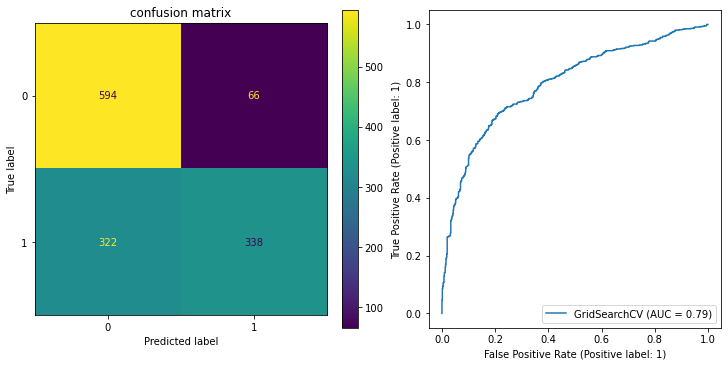

Wall time: 6.56 s


In [59]:
%%time
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_nb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', ComplementNB())
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_nb_params = {
                    'tvec__max_features': [1_000,1_500,1_600,2_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    'classifier__alpha' : [10**0, 10**1, 10**2]
                    }

# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # what object are we optimizing?
                        param_grid = pipe_tvec_nb_params, # what parameters values are we searching?
                       cv=5, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

run_model(gs_tvec_nb, X_train, y_train, X_test, y_test )

In [230]:
#df_coefs = get_coefs(gs_tvec_nb, X, y)

AttributeError: 'MultinomialNB' object has no attribute 'coef_'

## Modeling Using the TfidfVectorizer + Bagging Complement Naive Bayes

bagging_nb = BaggingClassifier(GaussianNB(), 
                               n_estimators=100, 
                               max_samples=1.0, 
                               max_features=5, 
                               bootstrap = True, 
                               bootstrap_features = True, 
                               random_state=0)

best_params: 
{'bagcnb__max_samples': 150, 'bagcnb__n_estimators': 1000, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.852
roc_auc_score on testing set: 0.793
perc_diff: 6.9 %

accuracy_score on testing set: 0.705

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            600           60
actual AskMen              329          331

plot confusion matrix and ROC curve


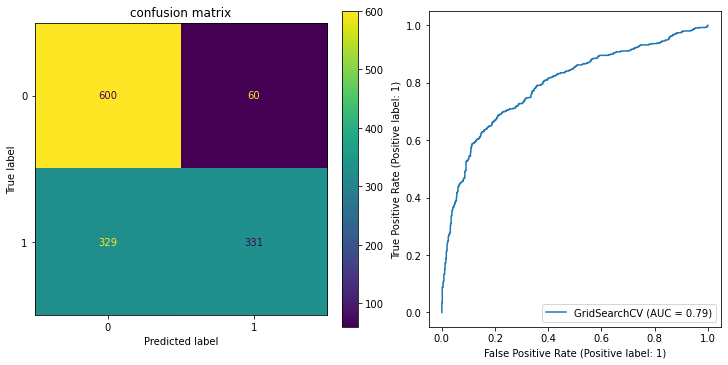

Wall time: 6min 13s


In [61]:
%%time

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_bagcnb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('bagcnb', BaggingClassifier(ComplementNB()))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_bagcnb_params = {
                    'tvec__max_features': [500, 1_000, 2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'bagcnb__n_estimators' : [1000, 1500],
                    'bagcnb__max_samples' : [50,100, 150],
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

# Instantiate GridSearchCV.
gs_tvec_bagcnb = GridSearchCV(pipe_tvec_bagcnb, # what object are we optimizing?
                        param_grid = pipe_tvec_bagcnb_params, # what parameters values are we searching?
                        cv=5, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

run_model(gs_tvec_bagcnb, X_train, y_train, X_test, y_test )

In [55]:
%%time

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_bagcnb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('bagcnb', BaggingClassifier(ComplementNB()))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_bagcnb_params = {
                    'tvec__max_features': [500, 1_000, 2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'bagcnb__n_estimators' : [1000, 1500],
                    'bagcnb__max_samples' : [50,100, 150],
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

# Instantiate GridSearchCV.
hgs_tvec_bagcnb = HalvingGridSearchCV(pipe_tvec_bagcnb, # what object are we optimizing?
                        param_grid = pipe_tvec_bagcnb_params, # what parameters values are we searching?
                        cv=5, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

run_model(hgs_tvec_bagcnb, X_train, y_train, X_test, y_test )

ValueError: 
All the 480 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\olive\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\olive\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\olive\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 297, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "C:\Users\olive\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 368, in _fit
    raise ValueError("max_samples must be in (0, n_samples]")
ValueError: max_samples must be in (0, n_samples]


## Modeling Using the TfidfVectorizer + SVM

best_params: 
{'svc__C': 1, 'svc__class_weight': None, 'tvec__max_features': 140, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}

roc_auc_score on training set: 0.944
roc_auc_score on testing set: 0.819
perc_diff: 13.2 %

accuracy_score on testing set: 0.754

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            554          106
actual AskMen              219          441

plot confusion matrix and ROC curve


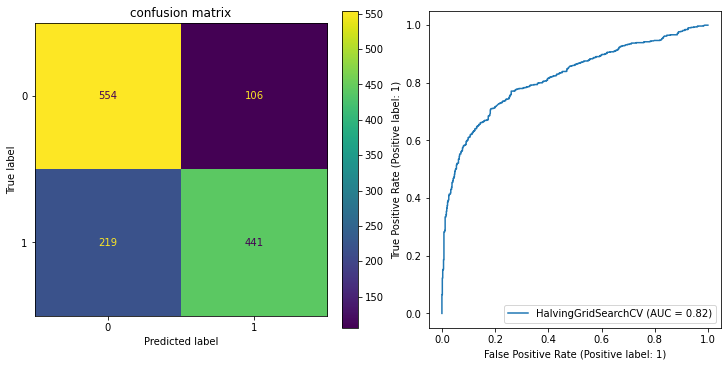

Wall time: 9.02 s


In [75]:
%%time
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_svc = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('svc', SVC(probability=True, random_state=42))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_svc_params = {
                    'tvec__max_features': [140, 150, 170],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    
    
                     #params of bagging naive bayes
                    'svc__C' : [10**-1, 10**0, 10**1],
                    'svc__class_weight' : [None, {0:1,1:5}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

# Instantiate GridSearchCV.
hgs_tvec_svc = HalvingGridSearchCV(pipe_tvec_svc, # what object are we optimizing?
                        param_grid = pipe_tvec_svc_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


run_model(hgs_tvec_svc, X_train, y_train, X_test, y_test )



{'svc__C': 1, 'svc__class_weight': None, 'tvec__max_features': 400, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}
score on training set: 0.974
score on testing set: 0.818
perc_diff: 16.0 %
                 pred AskWomen  pred AskMen
actual AskWomen            529          120
actual AskMen              199          440


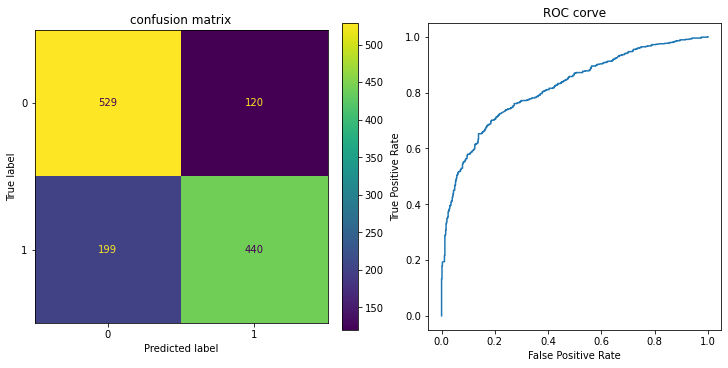

best_params: 
{'classifier__C': 1, 'classifier__penalty': 'l1', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.872
roc_auc_score on testing set: 0.812
perc_diff: 6.9 %

accuracy_score on testing set: 0.737

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            500          149
actual AskMen              193          456

plot confusion matrix and ROC curve


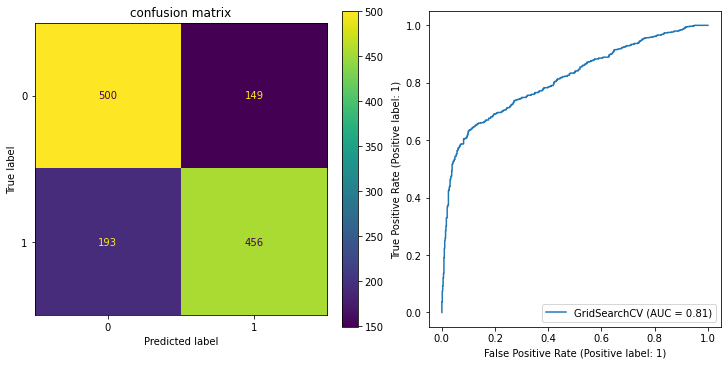

In [235]:
#df_coefs = get_coefs(gs_tvec_lr, X, y)

NameError: name 'features_final' is not defined

## Modeling Using the TfidfVectorizer + GradientBoosting

best_params: 
{'classifier__max_depth': 2, 'classifier__n_estimators': 100, 'tvec__max_features': 105, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

roc_auc_score on training set: 0.844
roc_auc_score on testing set: 0.808
perc_diff: 4.3 %

accuracy_score on testing set: 0.755

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            559          101
actual AskMen              222          438

plot confusion matrix and ROC curve


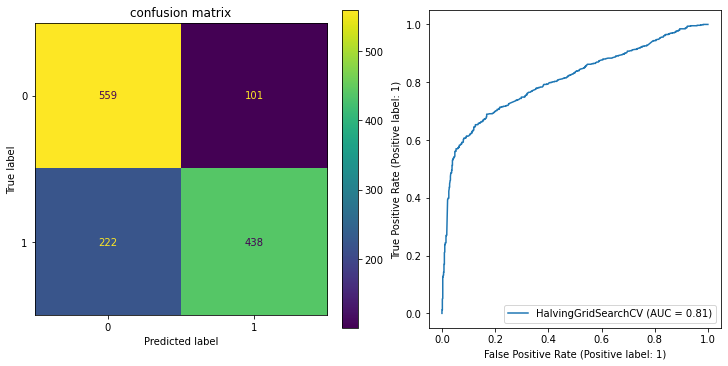

Wall time: 18.6 s


In [72]:
%%time
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_gb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', GradientBoostingClassifier(random_state=42))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_gb_params = {
                    'tvec__max_features': [105, 110, 115,120,125],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_estimators' : [100, 250,500],
                    'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

# Instantiate GridSearchCV.
hgs_tvec_gb = HalvingGridSearchCV(pipe_tvec_gb, # what object are we optimizing?
                        param_grid = pipe_tvec_gb_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


run_model(hgs_tvec_gb, X_train, y_train, X_test, y_test )


best_params: 
{'classifier__max_depth': 2, 'classifier__n_estimators': 250, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

roc_auc_score on training set: 0.916
roc_auc_score on testing set: 0.795
perc_diff: 13.2 %

accuracy_score on testing set: 0.733

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            510          139
actual AskMen              207          442

plot confusion matrix and ROC curve


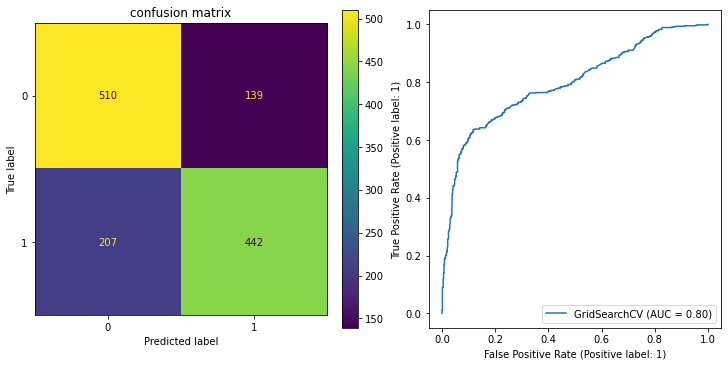

## Modeling Using the TfidfVectorizer + XGBoosting

best_params: 
{'classifier__colsample_bytree': 0.5, 'classifier__gamma': 0, 'classifier__max_depth': 7, 'classifier__reg_lambda': 10, 'classifier__scale_pos_weight': 5, 'classifier__subsample': 0.8, 'tvec__max_features': 105, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

roc_auc_score on training set: 0.849
roc_auc_score on testing set: 0.707
perc_diff: 16.7 %

accuracy_score on testing set: 0.560

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            107          553
actual AskMen               28          632

plot confusion matrix and ROC curve


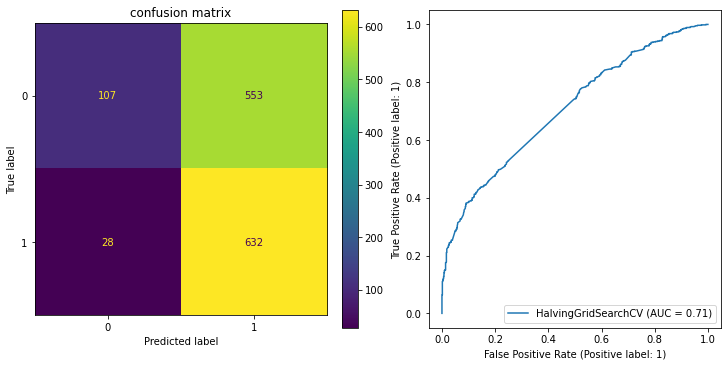

Wall time: 2min 15s


In [54]:

%%time
import xgboost as xgb
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_xgb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', xgb.XGBClassifier(objective="binary:logistic", verbose=None, seed=1121218))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_xgb_params = {
                    'tvec__max_features': [105, 110, 115,120,125],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                     "classifier__max_depth": [3, 4, 5, 7],
                     "classifier__gamma": [0, 0.25, 1],
                     "classifier__reg_lambda": [0, 1, 10],
                     "classifier__scale_pos_weight": [1, 3, 5],
                     "classifier__subsample": [0.8],  # Fix subsample
                     "classifier__colsample_bytree": [0.5],  # Fix colsample_bytree
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

# Instantiate GridSearchCV.
hgs_tvec_xgb = HalvingGridSearchCV(pipe_tvec_xgb, # what object are we optimizing?
                        param_grid = pipe_tvec_xgb_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


run_model(hgs_tvec_xgb, X_train, y_train, X_test, y_test )


best_params: 
{'classifier__max_depth': 2, 'classifier__n_estimators': 250, 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.926
roc_auc_score on testing set: 0.808
perc_diff: 12.7 %

accuracy_score on testing set: 0.744

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            510          139
actual AskMen              193          456

plot confusion matrix and ROC curve


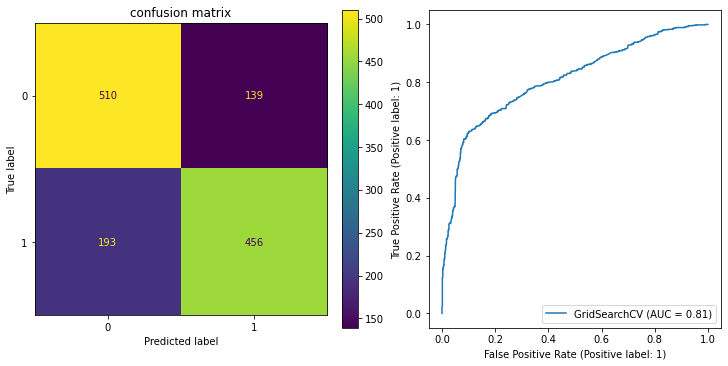

## Modeling Using the TfidfVectorizer + AdaBoostClassifier

best_params: 
{'classifier__n_estimators': 100, 'tvec__max_features': 200, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

roc_auc_score on training set: 0.877
roc_auc_score on testing set: 0.785
perc_diff: 10.5 %

accuracy_score on testing set: 0.720

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            508          152
actual AskMen              218          442

plot confusion matrix and ROC curve


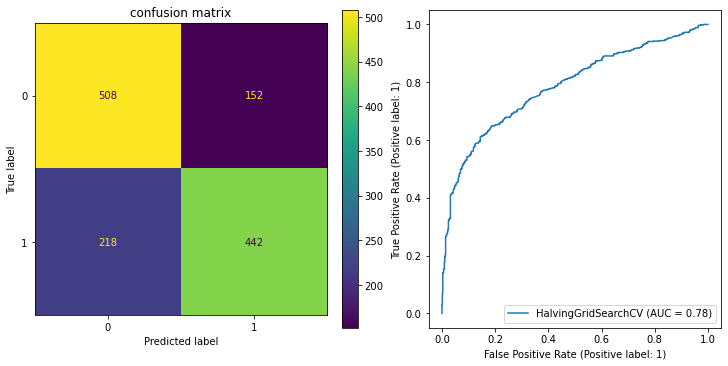

In [76]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_ab = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', AdaBoostClassifier(random_state=42))
                    ])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_ab_params = {
                    'tvec__max_features': [150,200, 300],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_estimators' : [100, 250],
                   # 'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }


# Instantiate GridSearchCV.
hgs_tvec_ab = HalvingGridSearchCV(pipe_tvec_ab, # what object are we optimizing?
                        param_grid = pipe_tvec_ab_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


run_model(hgs_tvec_ab, X_train, y_train, X_test, y_test )

best_params: 
{'classifier__n_estimators': 100, 'tvec__max_features': 300, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

roc_auc_score on training set: 0.896
roc_auc_score on testing set: 0.746
perc_diff: 16.7 %

accuracy_score on testing set: 0.691

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            473          176
actual AskMen              225          424

plot confusion matrix and ROC curve


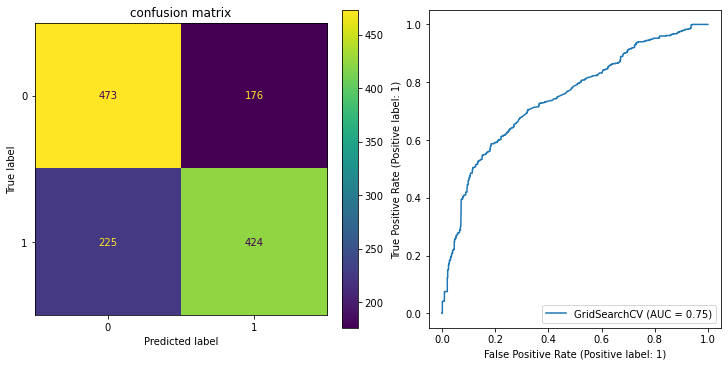

best_params: 
{'classifier__n_estimators': 100, 'tvec__max_features': 400, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}

roc_auc_score on training set: 0.901
roc_auc_score on testing set: 0.771
perc_diff: 14.4 %

accuracy_score on testing set: 0.716

confusion matrix: 
                 pred AskWomen  pred AskMen
actual AskWomen            487          162
actual AskMen              207          442

plot confusion matrix and ROC curve


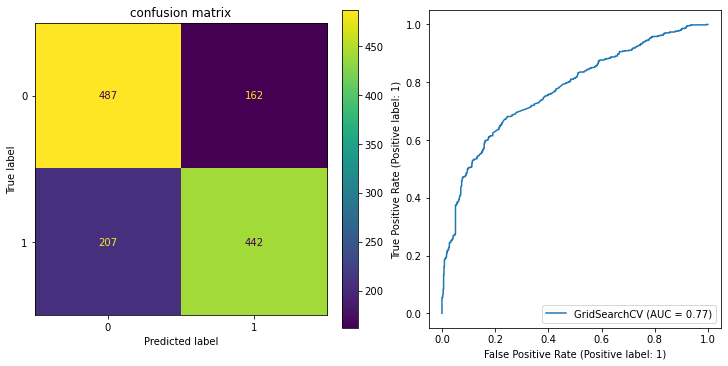

## Modeling Using the TfidfVectorizer +KNN

In [403]:
from sklearn.neighbors import KNeighborsClassifier

In [404]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_knn = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', KNeighborsClassifier())
                    ])

In [405]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_knn_params = {
                    'tvec__max_features': [ 1_500,2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_neighbors' : [10,25,50]
                   # 'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [406]:
# Instantiate GridSearchCV.
gs_tvec_knn = GridSearchCV(pipe_tvec_knn, # what object are we optimizing?
                        param_grid = pipe_tvec_knn_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'classifier__n_neighbors': 50, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.774
score on testing set: 0.754
perc_diff: 2.6 %
                 pred AskWomen  pred AskMen
actual AskWomen            309          340
actual AskMen              107          532


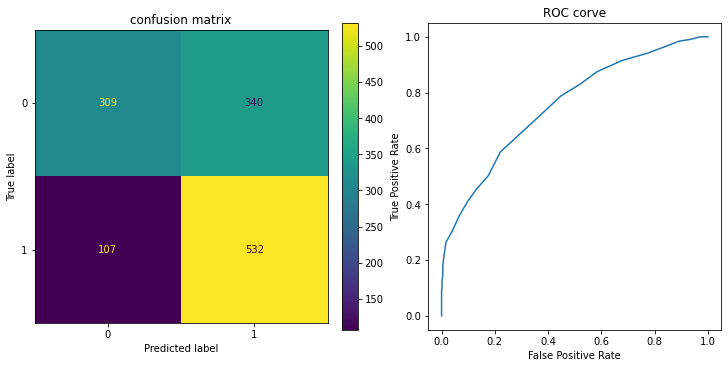

In [407]:
run_model(gs_tvec_knn, X_train, y_train, X_test, y_test )

## Conclusions and Recommendations

- We built several models and found lasso models had the best performance
- Based on the lasso model, we analyzed and found ' BsmtFin SF 1' and 'Fireplaces' as  recommended features for home improvements
- We built models for selected neighborhoods and  recommended some feature for home improvement
- The neighorhood models also suggest that it is better to do home improvement for newer houses or high value houses because it can create more value 

## Limitation and Future Enhancement
- Our 3 multiple regression models have very similar performance, indicating our model might be underfitting, adding more futures may increase model performance
- Our models cannot meet the LINE assumption, other non-regression models should be considered
- Many data are highly imbalance and barely useful. Data collector might redesign what to be collected in the future
- Many neigbhorhoods have insufficient data to build meaningful models. More data is needed